In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class DataPoint:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cluster = -1

class ClusterCenter:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance_to(self, point):
        return math.hypot(self.x - point.x, self.y - point.y)

def kmeans(points, n_clusters, init_method, max_iters=100):
    def initialize_centers():
        if init_method == 'random_space':
            return initialize_random_space()

        elif init_method == 'random_samples':
            return initialize_random_samples()

        elif init_method == 'max_distance':
            return initialize_max_distance()

        elif init_method == 'grid':
            return initialize_grid()

    def initialize_random_space():
        min_x, max_x = min(p.x for p in points), max(p.x for p in points)
        min_y, max_y = min(p.y for p in points), max(p.y for p in points)
        return [ClusterCenter(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)) for _ in range(n_clusters)]

    def initialize_random_samples():
        return [ClusterCenter(p.x, p.y) for p in random.sample(points, n_clusters)]

    def initialize_max_distance():
        centers = [ClusterCenter(p.x, p.y) for p in [random.choice(points)]]
        for _ in range(1, n_clusters):
            distances = [min(c.distance_to(p) for c in centers) for p in points]
            total = sum(distances)
            probabilities = [d / total for d in distances]
            new_center = random.choices(points, weights=probabilities)[0]
            centers.append(ClusterCenter(new_center.x, new_center.y))
        return centers

    def initialize_grid():
        min_x, max_x = min(p.x for p in points), max(p.x for p in points)
        min_y, max_y = min(p.y for p in points), max(p.y for p in points)
        return [
            ClusterCenter(min_x + (max_x - min_x) * i / (n_clusters - 1),
                          min_y + (max_y - min_y) * i / (n_clusters - 1))
            for i in range(n_clusters)
        ]

    centers = initialize_centers()
    iterations = 0

    for _ in range(max_iters):
        for p in points:
            p.cluster = np.argmin([c.distance_to(p) for c in centers])

        new_centers = []
        for i in range(n_clusters):
            cluster_points = [p for p in points if p.cluster == i]
            if cluster_points:
                new_x = sum(p.x for p in cluster_points) / len(cluster_points)
                new_y = sum(p.y for p in cluster_points) / len(cluster_points)
                new_centers.append(ClusterCenter(new_x, new_y))

        if all(math.isclose(c.x, nc.x) and math.isclose(c.y, nc.y) for c, nc in zip(centers, new_centers)):
            break

        centers = new_centers
        iterations += 1

    return iterations, centers


In [2]:
import matplotlib.pyplot as plt
import numpy as np

def test_initialization_methods(points, n_clusters, n_runs=5):
    methods = [
        ('random_space', 'Случайные точки пространства (а)'),
        ('random_samples', 'Случайные точки выборки (б)'),
        ('max_distance', 'Точки с макс. расстоянием (в)'),
        ('grid', 'Равномерная сетка (г)')
    ]

    def run_kmeans_for_method(method_code):
        iterations = []
        for _ in range(n_runs):
            iters, centers = kmeans(points, n_clusters, method_code)
            iterations.append(iters)
        return iterations, centers

    plt.figure(figsize=(18, 4.5))

    for idx, (method_code, method_name) in enumerate(methods, 1):
        iterations, centers = run_kmeans_for_method(method_code)

        plt.subplot(1, 4, idx)
        plot_clusters_and_centers(points, n_clusters, centers, iterations, method_name)

    plt.tight_layout()
    plt.show()

def plot_clusters_and_centers(points, n_clusters, centers, iterations, method_name):
    colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_points = [p for p in points if p.cluster == i]
        plt.scatter([p.x for p in cluster_points],
                    [p.y for p in cluster_points],
                    color=colors[i], alpha=0.6, s=30)

    plt.scatter([c.x for c in centers], [c.y for c in centers],
                marker='X', s=120, c='black', edgecolors='white')

    title = f"{method_name}\nИтераций: {np.mean(iterations):.1f} ± {np.std(iterations):.1f}"
    plt.title(title)

    plt.xticks([])
    plt.yticks([])


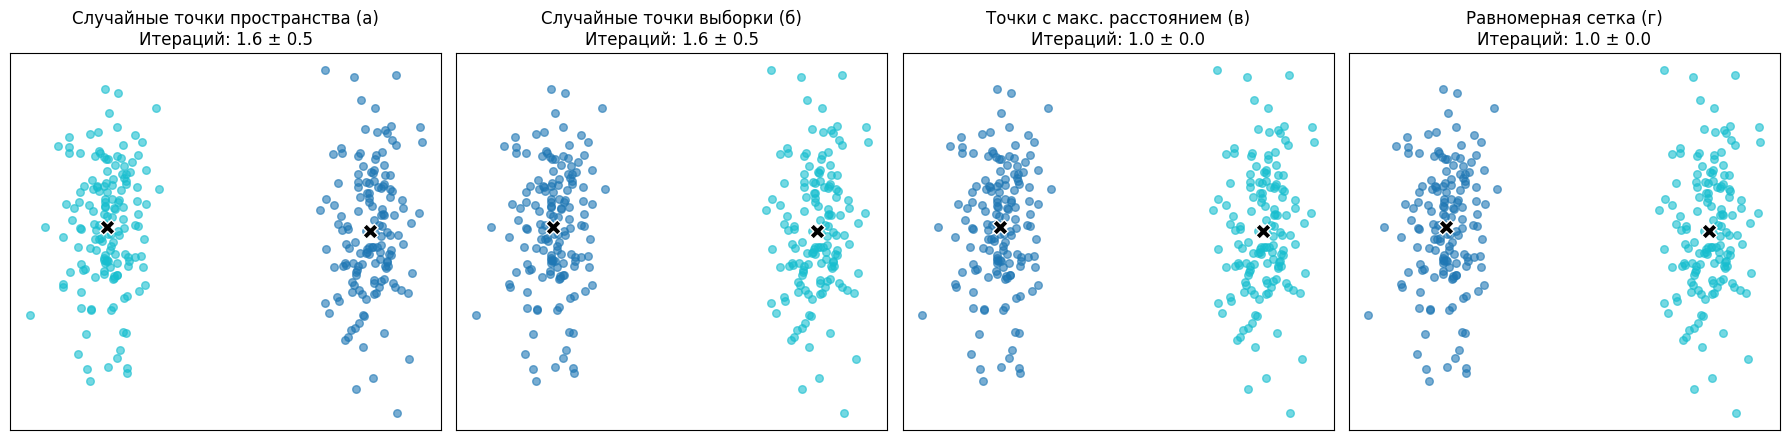

In [10]:
np.random.seed(152)

points = [
    DataPoint(np.random.normal(-3, 0.5), np.random.normal(3, 0.5))
    if random.random() < 0.5 else
    DataPoint(np.random.normal(3, 0.5), np.random.normal(3, 0.5))
    for _ in range(300)
]


test_initialization_methods(points, n_clusters=2)

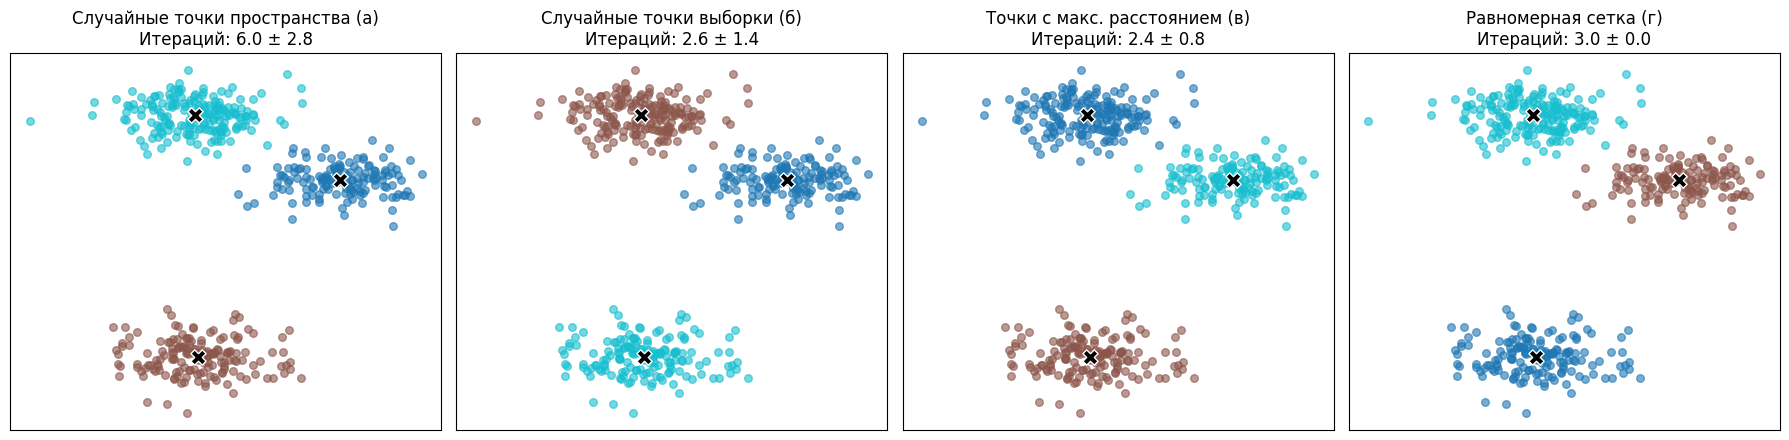

In [22]:
centers_true = [(-5, -5), (-5, 5),(-2.5,2.5)]

points = [
    DataPoint(np.random.normal(cx, 0.7), np.random.normal(cy, 0.7))
    for cx, cy in random.choices(centers_true, k=500)
]

test_initialization_methods(points, n_clusters=3)

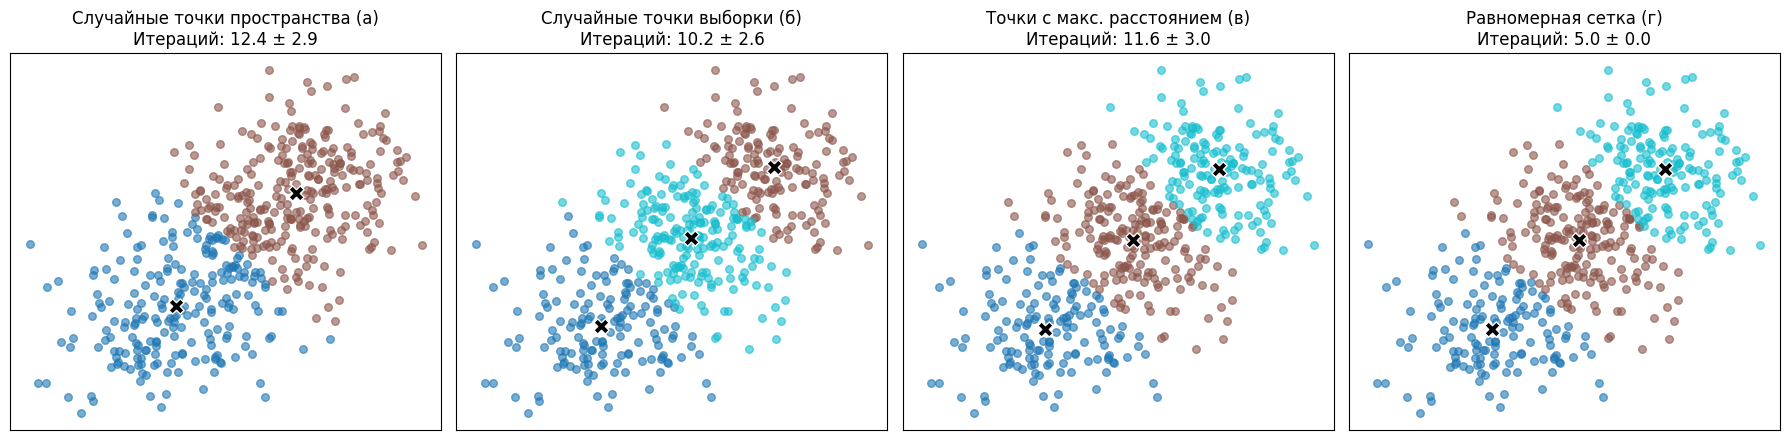

In [26]:
points = [
    DataPoint(np.random.normal(cluster * 1.5 - 0.75, 0.8),
              np.random.normal(cluster * 1.5 - 0.75, 0.8))
    for cluster in random.choices([0, 1, 2], k=500)
]


test_initialization_methods(points, n_clusters=3)

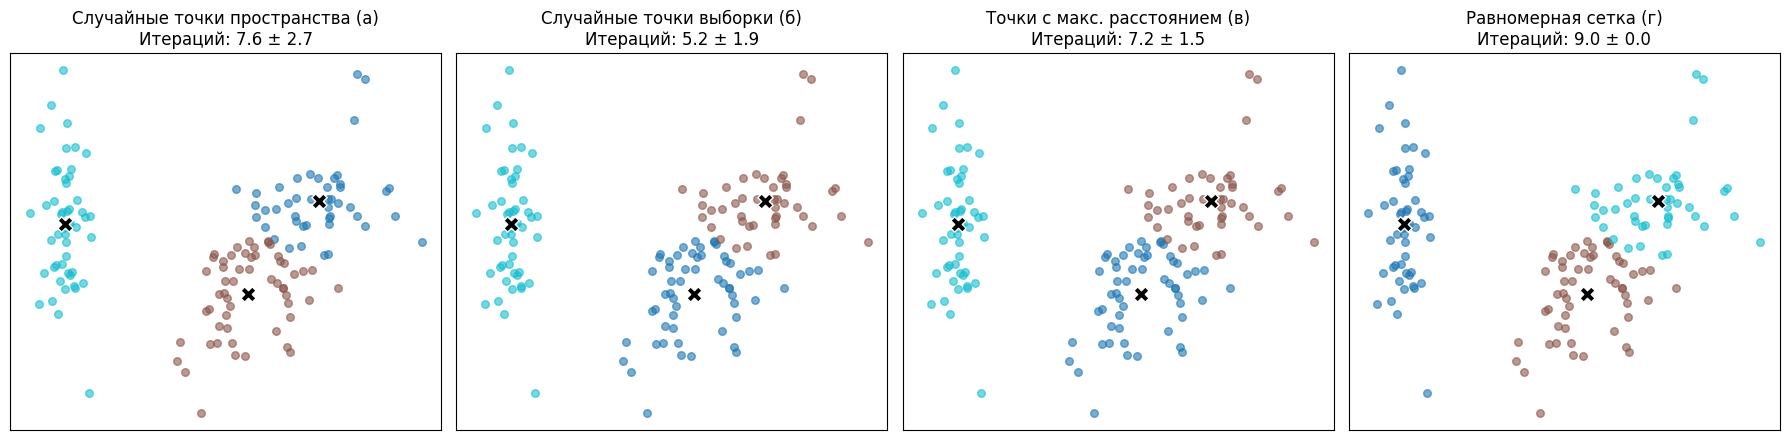

In [27]:
with open('/content/drive/MyDrive/Data Mining/3/iris.csv') as f:
    reader = csv.DictReader(f)
    data = [row for row in reader]

X = np.array([
    [
        float(row['sepal.length']),
        float(row['sepal.width']),
        float(row['petal.length']),
        float(row['petal.width'])
    ] for row in data
])
X = StandardScaler().fit_transform(X)
X = PCA(n_components=2).fit_transform(X)

points = [DataPoint(x[0], x[1]) for x in X]
test_initialization_methods(points, n_clusters=3)